In [111]:
import numpy as np
import os

from sklearn import svm

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.signal import welch
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,f1_score)

import matplotlib.pyplot as plt

In [112]:
from scipy import signal


def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=200, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

## Carregando o Dataset

In [113]:
caminhos = [os.path.join("src", nome) for nome in os.listdir("src")]
print(caminhos)

['src/1_EMG_Danilo_02-12-2019_201601.npy', 'src/1_EMG_Danilo_02-12-2019_201433.npy', 'src/1_EMG_Danilo_02-12-2019_201252.npy']


In [147]:
dataset = [np.load(gesture) for gesture in caminhos]
dataset = np.array(dataset)

dataset = dataset.swapaxes(2,3)
dataset = dataset.swapaxes(0,2)
dataset = dataset.reshape(4,5, 3*2000)
dataset = dataset.swapaxes(0,1)
print(dataset.shape)
#print(dataset[0,0,0])

(5, 4, 6000)


### Gesto , tentativas , eletrodos, dados

## Classificador

In [115]:
def vaiSVC(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, shuffle=True)


    for kernel in ['rbf']:#, 'linear']:
        for gamma in [0.001, 0.01, 0.1]:
            for C in [1, 10, 100, 1000]:
                classificador = []
                classificador = svm.SVC(gamma=gamma, C=C, kernel=kernel).fit(X_train, y_train)
                print('acuracia:', (classificador.score(X_test, y_test)) * 100, 'kernel:', kernel, 'gamma:', gamma, 'C:', C)
            

    cls = []
    cls = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', n_components=7).fit(X_train, y_train)
    print('\n acuracia:', cls.score(X_test, y_test) * 100)

## Plotting

In [150]:

def filtering (dataset):
    
    #print(dataset.shape[i])
    for i in range(dataset.shape[1]):
        plt.plot(dataset[i,:])
    plt.show()
    data_filtered = []
    print(dataset.shape)
    
    data_filtered = butter_notch(dataset, 60)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[i,:])
    plt.show()
    data_filtered = butter_highpass(data_filtered, 5)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[i,:])
    plt.show()
    data_filtered = butter_lowpass(data_filtered, 50)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[i,:])
    plt.show()
    
    return data_filtered


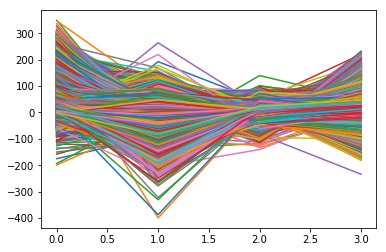

(5, 4, 6000)


In [ ]:
data_filtered = filtering(dataset)

In [ ]:
print(data_filtered.shape)

## Segmentação

In [79]:
salto = 20
segmento = 129
print(data_filtered.shape)
n_win = int((data_filtered.shape[-1] - segmento) / salto) + 1
ids = np.arange(n_win) * salto
x = np.array([data_filtered[:,:,k:(k + segmento)] for k in ids]).transpose(1, 2, 0, 3)
print(x.shape)



(5, 3, 2000)
(5, 3, 94, 129)


## Criador de Labels

## Domínio do Tempo

#### IEMG

(5, 3, 94)


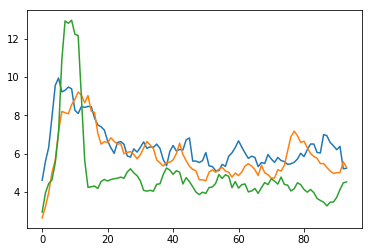

In [82]:

#mod = np.positive(x)
iemg =  np.sum(np.abs(x), axis=-1) / 129
print(iemg.shape)

for i in range(iemg.shape[1]):
    plt.plot(iemg[3,i,:])
plt.show()

#### VAR

(5, 3, 94)


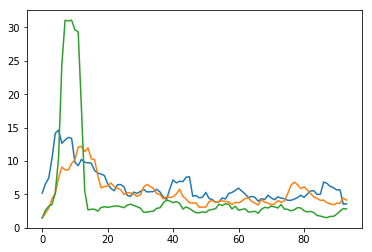

In [83]:
var = np.sum(x ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1)
print(var.shape)

for i in range(var.shape[1]):
    plt.plot(var[3,i,:])
plt.show()

#### RMS

(5, 3, 94)


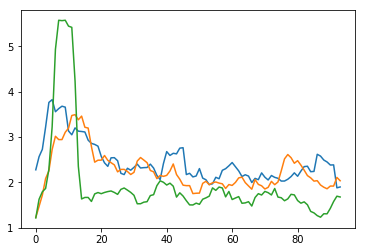

In [84]:
rms = np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1))
print(rms.shape)

for i in range(rms.shape[1]):
    plt.plot(rms[3,i,:])
plt.show()

#### Criando Vetor de Labels

In [85]:
X = np.concatenate((rms, var, iemg), axis=-1)
X = np.array(X)
#X = X.reshape(5*4, 282)
print(X.shape)

(5, 3, 282)


In [42]:
y = np.array([[str(i)] * int(X.shape[0] / 5) for i in range(5)])
y = y.reshape(y.shape[0] * y.shape[1])
y.shape



(5,)

In [43]:
vaiSVC(X,y)

acuracia: 0.0 kernel: rbf gamma: 0.001 C: 1
acuracia: 0.0 kernel: rbf gamma: 0.001 C: 10
acuracia: 0.0 kernel: rbf gamma: 0.001 C: 100
acuracia: 0.0 kernel: rbf gamma: 0.001 C: 1000
acuracia: 0.0 kernel: rbf gamma: 0.01 C: 1
acuracia: 0.0 kernel: rbf gamma: 0.01 C: 10
acuracia: 0.0 kernel: rbf gamma: 0.01 C: 100
acuracia: 0.0 kernel: rbf gamma: 0.01 C: 1000
acuracia: 0.0 kernel: rbf gamma: 0.1 C: 1
acuracia: 0.0 kernel: rbf gamma: 0.1 C: 10
acuracia: 0.0 kernel: rbf gamma: 0.1 C: 100
acuracia: 0.0 kernel: rbf gamma: 0.1 C: 1000


ValueError: The number of samples must be more than the number of classes.

# Domínio da Frequência


In [29]:
from scipy.signal import stft

print(data_filtered.shape)
_, _, w = stft(data_filtered, fs=200, nperseg=256, noverlap=32)
w = w.swapaxes(2,3)
print(w.shape)

(5, 4, 2000)
(5, 4, 10, 129)


#### PSD

In [30]:
def PSD(x):
    return np.sqrt(np.abs(x))

#### FMD

In [33]:
fmd = np.sum(PSD(w), axis=-1) / 2
print(fmd.shape)

(5, 4, 10)


#### MMDF

In [32]:
mmdf = np.sum(np.abs(w), axis=-1) / 2
print(mmdf.shape)

(5, 4, 10)
